In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_df=pd.read_csv("/content/TRAIN.csv")

In [ ]:
test_df=pd.read_csv("/content/TEST_FINAL.csv")

In [ ]:
test_df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount
0,T1188341,171,S4,L2,R3,2019-06-01,0,No
1,T1188342,172,S1,L1,R1,2019-06-01,0,No
2,T1188343,173,S4,L2,R1,2019-06-01,0,No
3,T1188344,174,S1,L1,R4,2019-06-01,0,No
4,T1188345,170,S1,L1,R2,2019-06-01,0,No


In [ ]:
train_df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


Data Processing

●	Data Cleaning: Address missing values, remove duplicates, and correct inconsistencies in the dataset.


Step 1: Address Missing Values

In [ ]:
# Dis# Display columns with missing values and their counts
missing_values = train_df.isnull().sum()
print(missing_values)
print("Missing values in each column:\n", missing_values[missing_values > 0])


ID               0
Store_id         0
Store_Type       0
Location_Type    0
Region_Code      0
Date             0
Holiday          0
Discount         0
#Order           0
Sales            0
dtype: int64
Missing values in each column:
 Series([], dtype: int64)


There are NO MISSING VALUES in the data

Step 2: Remove Duplicates

In [ ]:
# Check for duplicates
duplicates = train_df.duplicated()
print("Number of duplicate rows:", duplicates.sum())

Number of duplicate rows: 0


There are NO DUPLICATES in the data.

Step 3: Correct Inconsistencies

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             188340 non-null  object 
 1   Store_id       188340 non-null  int64  
 2   Store_Type     188340 non-null  object 
 3   Location_Type  188340 non-null  object 
 4   Region_Code    188340 non-null  object 
 5   Date           188340 non-null  object 
 6   Holiday        188340 non-null  int64  
 7   Discount       188340 non-null  object 
 8   #Order         188340 non-null  int64  
 9   Sales          188340 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 14.4+ MB


In [ ]:
# Convert 'Date' column to datetime format
train_df["Date"]=pd.to_datetime(train_df["Date"])


In [ ]:
cat_cols = ['Store_Type', 'Location_Type', 'Region_Code', 'Discount']
for col in cat_cols:
    train_df[col] = train_df[col].astype('category')


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ID             188340 non-null  object        
 1   Store_id       188340 non-null  int64         
 2   Store_Type     188340 non-null  category      
 3   Location_Type  188340 non-null  category      
 4   Region_Code    188340 non-null  category      
 5   Date           188340 non-null  datetime64[ns]
 6   Holiday        188340 non-null  int64         
 7   Discount       188340 non-null  category      
 8   #Order         188340 non-null  int64         
 9   Sales          188340 non-null  float64       
dtypes: category(4), datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 9.3+ MB


Handle Outliers:

In [ ]:
# Remove outliers using quantiles (optional)
Q1 = train_df['Sales'].quantile(0.25)
Q3 = train_df['Sales'].quantile(0.75)
IQR = Q3 - Q1
df = train_df[(train_df['Sales'] >= (Q1 - 1.5 * IQR)) & (train_df['Sales'] <= (Q3 + 1.5 * IQR))]


●	Feature Engineering: Develop new features that could enhance the model's predictive power, such as time-based aggregates (e.g., sales in the last week), ratios, or interaction terms between features.

1. Time-Based Aggregates

Rolling Sales and Orders:


In [ ]:
# Rolling sales and orders (last 7, 14, 30 days) for each store
train_df = train_df.sort_values(by=['Store_id', 'Date'])
train_df['Sales_7d'] = train_df.groupby('Store_id')['Sales'].transform(lambda x: x.rolling(7, min_periods=1).sum())
train_df['Sales_14d'] = train_df.groupby('Store_id')['Sales'].transform(lambda x: x.rolling(14, min_periods=1).sum())
train_df['Sales_30d'] = train_df.groupby('Store_id')['Sales'].transform(lambda x: x.rolling(30, min_periods=1).sum())


In [ ]:
train_df['Orders_7d'] = train_df.groupby('Store_id')['#Order'].transform(lambda x: x.rolling(7, min_periods=1).sum())
train_df['Orders_14d'] = train_df.groupby('Store_id')['#Order'].transform(lambda x: x.rolling(14, min_periods=1).sum())
train_df['Orders_30d'] = train_df.groupby('Store_id')['#Order'].transform(lambda x: x.rolling(30, min_periods=1).sum())


Lag Features:

In [ ]:
train_df['Sales_Lag_1'] = train_df.groupby('Store_id')['Sales'].shift(1)
train_df['Sales_Lag_7'] = train_df.groupby('Store_id')['Sales'].shift(7)
train_df['Orders_Lag_1'] = train_df.groupby('Store_id')['#Order'].shift(1)
train_df['Orders_Lag_7'] = train_df.groupby('Store_id')['#Order'].shift(7)

Cumulative Sales:

In [ ]:
# Cumulative Sales and Orders per store
train_df['Cumulative_Sales'] = train_df.groupby('Store_id')['Sales'].cumsum()
train_df['Cumulative_Orders'] = train_df.groupby('Store_id')['#Order'].cumsum()

2. Discount-Related Features

In [ ]:
# Discount duration (number of consecutive days of discount)
train_df['Discount_Duration'] = train_df.groupby(['Store_id', 'Discount'])['Date'].transform(lambda x: (x.diff().dt.days != 1).cumsum())

In [ ]:
# Discount and holiday interaction term
train_df['Discount_and_Holiday'] = train_df['Discount'].astype(str) + '_' + train_df['Holiday'].astype(str)

3. Store-Based Aggregates

In [ ]:
# Store-specific rolling averages
train_df['Store_Sales_7d'] = train_df.groupby(['Store_id'])['Sales'].transform(lambda x: x.rolling(7, min_periods=1).mean())
train_df['Store_Orders_7d'] = train_df.groupby(['Store_id'])['#Order'].transform(lambda x: x.rolling(7, min_periods=1).mean())


In [ ]:
# Aggregates based on Store_Type, Location_Type, and Region_Code
train_df['Avg_Sales_Store_Type'] = train_df.groupby('Store_Type')['Sales'].transform('mean')
train_df['Avg_Sales_Location_Type'] = train_df.groupby('Location_Type')['Sales'].transform('mean')
train_df['Avg_Sales_Region_Code'] = train_df.groupby('Region_Code')['Sales'].transform('mean')


4. Ratios and Interaction Terms

In [ ]:
#Order-to-Sales ratio
train_df['Order_to_Sales_Ratio'] = train_df['#Order'] / (train_df['Sales'] + 1e-5)  # adding small value to avoid division by zero

# Discount to Sales ratio over last 30 days
train_df['Discount_to_Sales_30d'] = train_df.groupby(['Store_id', 'Discount'])['Sales'].transform(lambda x: x.rolling(30, min_periods=1).mean())

# Holiday interaction terms
train_df['Holiday_and_Location_Type'] = train_df['Holiday'].astype(str) + '_' + train_df['Location_Type'].astype(str)
train_df['Holiday_and_Store_Type'] = train_df['Holiday'].astype(str) + '_' + train_df['Store_Type'].astype(str)


5. Temporal Features

In [ ]:
# Extract day, month, week of year, and day of week
train_df['Day'] = train_df['Date'].dt.day
train_df['Month'] = train_df['Date'].dt.month
train_df['WeekOfYear'] = train_df['Date'].dt.isocalendar().week
train_df['DayOfWeek'] = train_df['Date'].dt.dayofweek  # 0 = Monday, 6 = Sunday

In [ ]:
# Flags for month start and end
train_df['Is_Month_End'] = train_df['Date'].dt.is_month_end.astype(int)
train_df['Is_Month_Start'] = train_df['Date'].dt.is_month_start.astype(int)

In [ ]:
# Display the DataFrame with new features
train_df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales,...,Order_to_Sales_Ratio,Discount_to_Sales_30d,Holiday_and_Location_Type,Holiday_and_Store_Type,Day,Month,WeekOfYear,DayOfWeek,Is_Month_End,Is_Month_Start
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84,...,0.001284,7011.840,1_L3,1_S1,1,1,1,0,0,1
607,T1000608,1,S1,L3,R1,2018-01-02,0,Yes,60,42369.00,...,0.001416,24690.420,0_L3,0_S1,2,1,1,1,0,0
1046,T1001047,1,S1,L3,R1,2018-01-03,0,Yes,72,50037.00,...,0.001439,33139.280,0_L3,0_S1,3,1,1,2,0,0
1207,T1001208,1,S1,L3,R1,2018-01-04,0,Yes,64,44397.00,...,0.001442,35953.710,0_L3,0_S1,4,1,1,3,0,0
1752,T1001753,1,S1,L3,R1,2018-01-05,0,Yes,63,47604.00,...,0.001323,38283.768,0_L3,0_S1,5,1,1,4,0,0


In [ ]:
train_df.columns

Index(['ID', 'Store_id', 'Store_Type', 'Location_Type', 'Region_Code', 'Date',
       'Holiday', 'Discount', '#Order', 'Sales', 'Sales_7d', 'Sales_14d',
       'Sales_30d', 'Orders_7d', 'Orders_14d', 'Orders_30d', 'Sales_Lag_1',
       'Sales_Lag_7', 'Orders_Lag_1', 'Orders_Lag_7', 'Cumulative_Sales',
       'Cumulative_Orders', 'Discount_Duration', 'Discount_and_Holiday',
       'Store_Sales_7d', 'Store_Orders_7d', 'Avg_Sales_Store_Type',
       'Avg_Sales_Location_Type', 'Avg_Sales_Region_Code',
       'Order_to_Sales_Ratio', 'Discount_to_Sales_30d',
       'Holiday_and_Location_Type', 'Holiday_and_Store_Type', 'Day', 'Month',
       'WeekOfYear', 'DayOfWeek', 'Is_Month_End', 'Is_Month_Start'],
      dtype='object')

●	Data Transformation: Scale numerical features and encode categorical variables to prepare the data for modeling. Techniques like normalization or standardization and one-hot encoding or label encoding can be applied.

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
# List of numerical and categorical columns
numerical_features = ['#Order', 'Sales', 'Sales_7d', 'Sales_14d', 'Sales_30d',
                      'Orders_7d', 'Orders_14d', 'Orders_30d', 'Sales_Lag_1', 'Sales_Lag_7',
                      'Orders_Lag_1', 'Orders_Lag_7', 'Cumulative_Sales', 'Cumulative_Orders',
                      'Order_to_Sales_Ratio', 'Discount_to_Sales_30d',
                      'Store_Sales_7d', 'Store_Orders_7d', 'Avg_Sales_Store_Type',
                      'Avg_Sales_Location_Type', 'Avg_Sales_Region_Code',
                      'Day', 'Month', 'WeekOfYear', 'DayOfWeek']

categorical_features = ['Store_Type', 'Location_Type', 'Region_Code',
                        'Discount', 'Discount_and_Holiday', 'Holiday_and_Location_Type',
                        'Holiday_and_Store_Type']

In [ ]:
# Pipeline for numerical features (Standardization)
numerical_transformer = StandardScaler()

# Pipeline for categorical features (One-hot encoding)
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

In [ ]:
# Combine transformations into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
# Apply transformations
train_df_preprocessed = preprocessor.fit_transform(train_df)

In [ ]:
# Convert the transformed data back to a DataFrame for easy inspection
# Get column names for transformed categorical features
cat_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

In [ ]:
# Combine numerical and categorical columns
transformed_columns = numerical_features + list(cat_columns)
train_df_transformed = pd.DataFrame(train_df_preprocessed, columns=transformed_columns)

In [ ]:
# Display the transformed DataFrame
train_df_transformed.head()

,#Order,Sales,Sales_7d,Sales_14d,Sales_30d,Orders_7d,Orders_14d,Orders_30d,Sales_Lag_1,Sales_Lag_7,...,Holiday_and_Location_Type_1_L3,Holiday_and_Location_Type_1_L4,Holiday_and_Location_Type_1_L5,Holiday_and_Store_Type_0_S2,Holiday_and_Store_Type_0_S3,Holiday_and_Store_Type_0_S4,Holiday_and_Store_Type_1_S1,Holiday_and_Store_Type_1_S2,Holiday_and_Store_Type_1_S3,Holiday_and_Store_Type_1_S4
0,-1.943251,-1.938189,-2.761022,-2.881054,-2.845891,-2.531903,-2.578983,-2.523074,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.269328,-0.022503,-2.358502,-2.671964,-2.748350,-2.205677,-2.413254,-2.446500,-1.937765,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.124537,0.392957,-1.883133,-2.425032,-2.633156,-1.814205,-2.214379,-2.354611,-0.022502,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.138039,0.087376,-1.461346,-2.205934,-2.530946,-1.466231,-2.037601,-2.272932,0.392866,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.170861,0.261135,-1.009092,-1.971010,-2.421353,-1.123693,-1.863586,-2.192530,0.087353,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test_df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount
0,T1188341,171,S4,L2,R3,2019-06-01,0,No
1,T1188342,172,S1,L1,R1,2019-06-01,0,No
2,T1188343,173,S4,L2,R1,2019-06-01,0,No
3,T1188344,174,S1,L1,R4,2019-06-01,0,No
4,T1188345,170,S1,L1,R2,2019-06-01,0,No


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Load the training and testing data
train_df = pd.read_csv('/content/TRAIN.csv')
test_df = pd.read_csv('/content/TEST_FINAL.csv')

# Convert 'Date' column to datetime if necessary
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Define numerical and categorical features
#numerical_features = ['#Order', 'Sales_7d', 'Sales_14d', 'Sales_30d',
                     # 'Orders_7d', 'Orders_14d', 'Orders_30d', 'Sales_Lag_1', 'Sales_Lag_7',
                    # 'Orders_Lag_1', 'Orders_Lag_7', 'Cumulative_Sales', 'Cumulative_Orders',
                     # 'Order_to_Sales_Ratio', 'Discount_to_Sales_30d',
                      #'Store_Sales_7d', 'Store_Orders_7d', 'Avg_Sales_Store_Type',
                      #'Avg_Sales_Location_Type', 'Avg_Sales_Region_Code',
                      #'Day', 'Month', 'WeekOfYear', 'DayOfWeek']

numerical_features = ['Store_id','Holiday']


categorical_features = ['Store_Type', 'Location_Type', 'Region_Code',
                        'Discount']

# Separate the target variable in training data
X = train_df.drop(columns=['Sales'])
y = train_df['Sales']

# Split `train_df` into training and validation sets (e.g., 80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the transformer for scaling and encoding
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False,handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

#categorical_transformer = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')


# Fit the transformer on the training data and apply to the validation and test sets
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(test_df)  # Apply transformation to `test_df` without fitting

# Convert transformed arrays back into DataFrames
cat_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
transformed_columns = numerical_features + list(cat_columns)
X_train_transformed = pd.DataFrame(X_train_transformed, columns=transformed_columns)
X_val_transformed = pd.DataFrame(X_val_transformed, columns=transformed_columns)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=transformed_columns)

# Display shapes of the processed training, validation, and test sets
print("Transformed training set shape:", X_train_transformed.shape)
print("Transformed validation set shape:", X_val_transformed.shape)
print("Transformed test set shape:", X_test_transformed.shape)


Transformed training set shape: (150672, 13)
Transformed validation set shape: (37668, 13)
Transformed test set shape: (22265, 13)


Model Selection

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize the Linear Regression model
baseline_model = LinearRegression()

# Fit the model on the training data
baseline_model.fit(X_train_transformed, y_train)

# Make predictions on the validation set
y_val_pred = baseline_model.predict(X_val_transformed)

# Calculate evaluation metrics
mse = mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_val_pred)

# Print evaluation metrics
print("Baseline Model Performance on Validation Set:")
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)


Baseline Model Performance on Validation Set:
Mean Absolute Error (MAE): 8677.966717174424
Mean Squared Error (MSE): 153217672.26270828
Root Mean Squared Error (RMSE): 12378.11262926252
R-squared (R2): 0.546793287511736


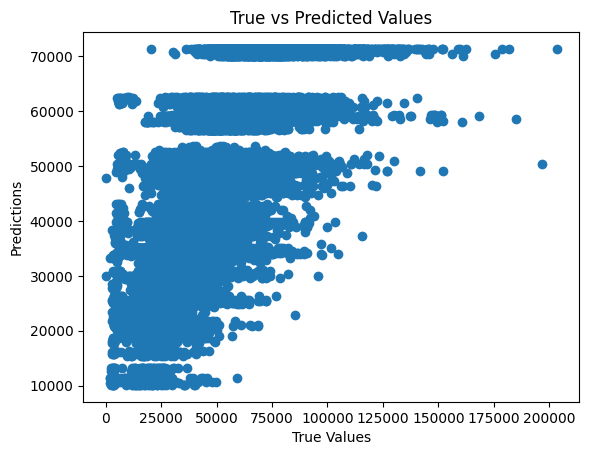

In [ ]:
plt.scatter(y_val, y_val_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs Predicted Values")
plt.show()


In [ ]:
#import pandas as pd

In [ ]:
#train_df=pd.read_csv("/content/TRAIN.csv")

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Assume sales data is a time series indexed by date
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df.set_index('Date', inplace=True)

# Fit an ARIMA model (example parameters)
p, d, q = 1, 1, 1  # Adjust these based on your ACF/PACF analysis or grid search
arima_model = ARIMA(train_df['Sales'], order=(p, d, q))
arima_model_fit = arima_model.fit()

# Forecasting on validation set
forecast = arima_model_fit.forecast(steps=len(X_val))  # Adjust `steps` as needed

# Evaluate
mse = mean_squared_error(y_val, forecast)
rmse = np.sqrt(mse)
print(f"ARIMA Model RMSE: {rmse}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


ARIMA Model RMSE: 18862.86916532888


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Set the seasonal order, example with a weekly seasonality (s=7 for daily data)
P, D, Q, s = 1, 1, 1, 7  # Adjust based on seasonality

# Fit SARIMA model
sarima_model = SARIMAX(train_df['Sales'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_model_fit = sarima_model.fit()

# Forecast on validation set
forecast_sarima = sarima_model_fit.get_forecast(steps=len(X_val)).predicted_mean

# Evaluate
mse_sarima = mean_squared_error(y_val, forecast_sarima)
rmse_sarima = np.sqrt(mse_sarima)
print(f"SARIMA Model RMSE: {rmse_sarima}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


SARIMA Model RMSE: 19245.26259029263


In [ ]:
!pip install prophet


In [ ]:
from prophet import Prophet

# Prepare data for Prophet
train_df_prophet = train_df.reset_index()[['Date', 'Sales']]
train_df_prophet.columns = ['ds', 'y']  # Prophet requires columns to be named 'ds' and 'y'

# Initialize and fit the Prophet model
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
prophet_model.fit(train_df_prophet)

# Create future dates for validation period
future_dates = prophet_model.make_future_dataframe(periods=len(X_val))

# Forecast
forecast_prophet = prophet_model.predict(future_dates)

# Extract forecasted values for validation period
forecast_y = forecast_prophet['yhat'][-len(X_val):].values

# Evaluate
mse_prophet = mean_squared_error(y_val, forecast_y)
rmse_prophet = np.sqrt(mse_prophet)
print(f"Prophet Model RMSE: {rmse_prophet}")


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6npxb8g3/ua1l2jfv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6npxb8g3/7e2sp4cs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37183', 'data', 'file=/tmp/tmp6npxb8g3/ua1l2jfv.json', 'init=/tmp/tmp6npxb8g3/7e2sp4cs.json', 'output', 'file=/tmp/tmp6npxb8g3/prophet_model76wh0qv_/prophet_model-20241109054324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:43:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:45:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Model RMSE: 9344059.108141297


Among these three ARIMA, SARIMA, or Prophet SARIMA has given the best result

●	Tree-Based Models: Random forests and gradient boosting machines (e.g., XGBoost, LightGBM) that can handle nonlinear relationships and interactions between features.

Tree-based models, like Random Forests and Gradient Boosting Machines (e.g., XGBoost and LightGBM), are excellent choices for handling complex, nonlinear relationships in your data. They also automatically capture feature interactions, which can significantly enhance predictive power, especially when traditional time series models struggle with non-stationary or highly nonlinear data.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)

# Train the model on the training data
rf_model.fit(X_train_transformed, y_train)

# Make predictions on the validation set
y_val_pred_rf = rf_model.predict(X_val_transformed)

# Evaluate the model
mse_rf = mean_squared_error(y_val, y_val_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_val, y_val_pred_rf)
r2_rf = r2_score(y_val, y_val_pred_rf)

print("Random Forest Model Performance on Validation Set:")
print("Mean Absolute Error (MAE):", mae_rf)
print("Mean Squared Error (MSE):", mse_rf)
print("Root Mean Squared Error (RMSE):", rmse_rf)
print("R-squared (R2):", r2_rf)


Random Forest Model Performance on Validation Set:
Mean Absolute Error (MAE): 7899.998292041057
Mean Squared Error (MSE): 126093802.30401266
Root Mean Squared Error (RMSE): 11229.149669677248
R-squared (R2): 0.6270237188477663


In [ ]:
from xgboost import XGBRegressor

# Initialize the XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Train the model on the training data
xgb_model.fit(X_train_transformed, y_train)

# Make predictions on the validation set
y_val_pred_xgb = xgb_model.predict(X_val_transformed)

# Evaluate the model
mse_xgb = mean_squared_error(y_val, y_val_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_val, y_val_pred_xgb)
r2_xgb = r2_score(y_val, y_val_pred_xgb)

print("XGBoost Model Performance on Validation Set:")
print("Mean Absolute Error (MAE):", mae_xgb)
print("Mean Squared Error (MSE):", mse_xgb)
print("Root Mean Squared Error (RMSE):", rmse_xgb)
print("R-squared (R2):", r2_xgb)


XGBoost Model Performance on Validation Set:
Mean Absolute Error (MAE): 7909.374071625783
Mean Squared Error (MSE): 127332081.00898792
Root Mean Squared Error (RMSE): 11284.15176293672
R-squared (R2): 0.6233609806483253


In [ ]:
from lightgbm import LGBMRegressor

# Initialize the LightGBM Regressor
lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Train the model on the training data
lgbm_model.fit(X_train_transformed, y_train)

# Make predictions on the validation set
y_val_pred_lgbm = lgbm_model.predict(X_val_transformed)

# Evaluate the model
mse_lgbm = mean_squared_error(y_val, y_val_pred_lgbm)
rmse_lgbm = np.sqrt(mse_lgbm)
mae_lgbm = mean_absolute_error(y_val, y_val_pred_lgbm)
r2_lgbm = r2_score(y_val, y_val_pred_lgbm)

print("LightGBM Model Performance on Validation Set:")
print("Mean Absolute Error (MAE):", mae_lgbm)
print("Mean Squared Error (MSE):", mse_lgbm)
print("Root Mean Squared Error (RMSE):", rmse_lgbm)
print("R-squared (R2):", r2_lgbm)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 276
[LightGBM] [Info] Number of data points in the train set: 150672, number of used features: 13
[LightGBM] [Info] Start training from score 42774.516131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

●	Deep Learning Models: Neural networks, especially LSTM (Long Short-Term Memory) models, which are well-suited for sequences like time series data.

LSTM (Long Short-Term Memory) networks are ideal for time series forecasting as they can capture complex temporal dependencies.

In [ ]:
!pip install tensorflow

In [ ]:
train_df=pd.read_csv("/content/TRAIN.csv")

In [ ]:
tesr_df=pd.read_csv("/content/TEST_FINAL.csv")

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

# Ensure Date is in datetime format and set it as index for time series
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df.set_index('Date', inplace=True)

# Use only the necessary columns for LSTM training
train_data = train_df[['Sales', 'Store_id', 'Holiday']]  # Include any other features you want

# Standardize the data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)

# Define the number of timesteps (e.g., use the last 7 days to predict the next day)
timesteps = 7

# Helper function to create sequences
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i + timesteps][0])  # Target is the 'Sales' column
    return np.array(X), np.array(y)

# Generate sequences from training data
X_train, y_train = create_sequences(train_data_scaled, timesteps)


In [ ]:
# Define the LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
4709/4709 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - loss: 0.8007 - val_loss: 0.9924
Epoch 2/10
4709/4709 ━━━━━━━━━━━━━━━━━━━━ 74s 7ms/step - loss: 0.8101 - val_loss: 0.9964
Epoch 3/10
4709/4709 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - loss: 0.8000 - val_loss: 0.9956
Epoch 4/10
4709/4709 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 0.7924 - val_loss: 0.9957
Epoch 5/10
4709/4709 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 0.7895 - val_loss: 0.9928
Epoch 6/10
4709/4709 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 0.7938 - val_loss: 0.9927
Epoch 7/10
4709/4709 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - loss: 0.7973 - val_loss: 0.9919
Epoch 8/10
4709/4709 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - loss: 0.7981 - val_loss: 0.9922
Epoch 9/10
4709/4709 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - loss: 0.8059 - val_loss: 0.9917
Epoch 10/10
4709/4709 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 0.8045 - val_loss: 0.9909


In [ ]:
# Predict on the training set
y_train_pred = model.predict(X_train)

# Inverse transform to get the original scale for 'Sales'
y_train_pred = scaler.inverse_transform(
    np.concatenate([y_train_pred, np.zeros((y_train_pred.shape[0], train_data.shape[1] - 1))], axis=1))[:, 0]
y_train_true = scaler.inverse_transform(
    np.concatenate([y_train.reshape(-1, 1), np.zeros((y_train.shape[0], train_data.shape[1] - 1))], axis=1))[:, 0]

# Calculate RMSE on the training set
train_rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
print("Training RMSE:", train_rmse)


5886/5886 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
Training RMSE: 16838.66157258379


In [ ]:
# Redefine the columns for scaling, excluding 'Sales' to ensure compatibility with test data
features_for_scaling = ['Store_id', 'Holiday']  # Adjust based on the columns available in test_df

# Scale only the selected features
scaler_features = StandardScaler()
train_features_scaled = scaler_features.fit_transform(train_df[features_for_scaling])

# Create a combined DataFrame with scaled features and original Sales
train_data_scaled = np.concatenate([train_df[['Sales']].values, train_features_scaled], axis=1)

# Define the number of timesteps (e.g., last 7 days to predict the next day)
timesteps = 7

# Generate sequences from scaled training data
X_train, y_train = create_sequences(train_data_scaled, timesteps)

# Scale the test data with the same scaler
test_data_scaled = scaler_features.transform(test_df[features_for_scaling])

# Concatenate the last part of train data to ensure continuity in the test sequence
test_data_combined = np.concatenate((train_features_scaled[-timesteps:], test_data_scaled), axis=0)

# Generate test sequences for prediction
X_test, _ = create_sequences(test_data_combined, timesteps)


In [ ]:
# Make predictions using your trained model on X_test
y_test_pred_scaled = model.predict(X_train)

# Inverse transform the predictions for 'Sales' only, restoring them to the original scale
# We use np.zeros to ensure compatibility with the scaler's expected number of features
# We are assuming 'Sales' is the first column, as used in `train_data_scaled`

# Initialize an array of zeros to fit the required dimensions for inverse transformation
# Here, `y_test_pred_scaled.shape[0]` is the number of predictions, and `len(features_for_scaling)` is the number of features used for scaling
zeros_for_inverse = np.zeros((y_test_pred_scaled.shape[0], len(features_for_scaling)))

# Concatenate predicted sales with zeros for other features to match scaler input structure
y_test_pred_combined = np.concatenate([y_test_pred_scaled, zeros_for_inverse], axis=1)

# Inverse transform the combined array
y_test_pred = scaler.inverse_transform(y_test_pred_combined)[:, 0]  # Extract 'Sales' column only

# Output predictions
print("Predictions on Test Data:", y_test_pred)


5886/5886 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
Predictions on Test Data: [69698.34961838 69698.34961838 69698.34961838 ... 69698.34961838
 69698.34961838 69698.34961838]


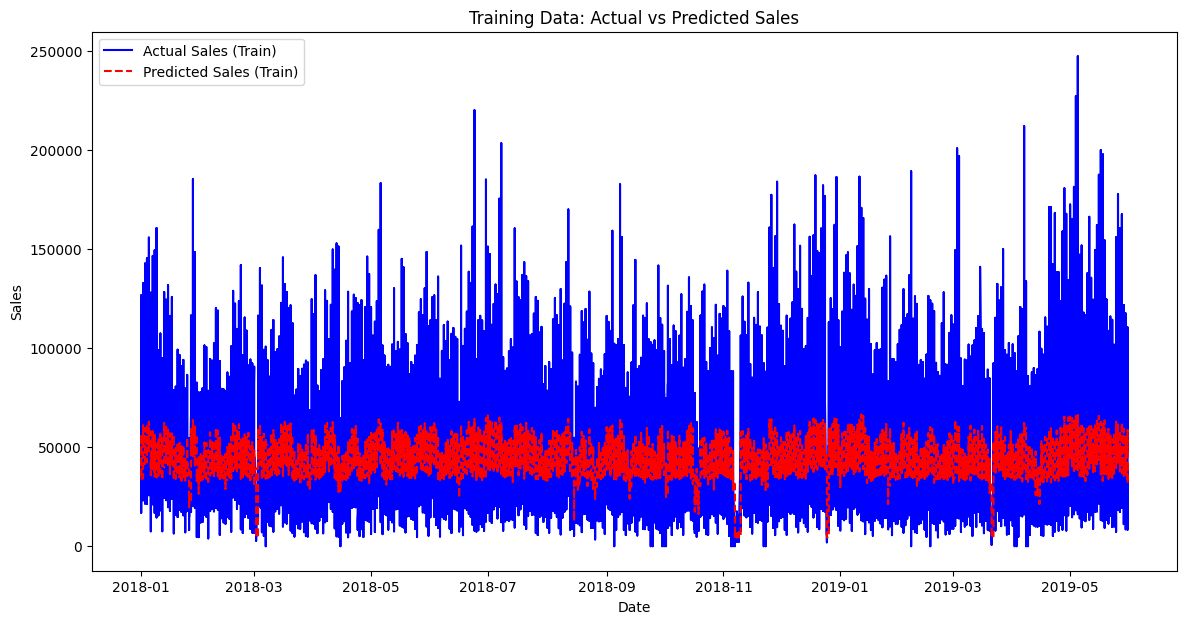

In [ ]:
import matplotlib.pyplot as plt

# Plot predictions vs actual values on the training set
plt.figure(figsize=(14, 7))
plt.plot(train_df.index[-len(y_train_true):], y_train_true, color='blue', label="Actual Sales (Train)")
plt.plot(train_df.index[-len(y_train_pred):], y_train_pred, color='red', linestyle='--', label="Predicted Sales (Train)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Training Data: Actual vs Predicted Sales")
plt.legend()
plt.show()




Ensemble Techniques: Combine predictions from multiple models to improve accuracy and robustness.

1. Training Multiple Models

In [ ]:
# SARIMA Model
validation_start = train_df.index[-30]  # Start 30 days from the end of train_df (or adjust as needed)
validation_end = train_df.index[-1]

sarima_pred = sarima_model_fit.predict(start=validation_start, end=validation_end)

# Prophet Model
prophet_model = Prophet()
prophet_model.fit(train_df_prophet)  # Ensure data is in Prophet's required format
prophet_pred = prophet_model.predict(future_dates)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6npxb8g3/1i4usff7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6npxb8g3/isc70g0c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37946', 'data', 'file=/tmp/tmp6npxb8g3/1i4usff7.json', 'init=/tmp/tmp6npxb8g3/isc70g0c.json', 'output', 'file=/tmp/tmp6npxb8g3/prophet_model468wvfgs/prophet_model-20241109055429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:54:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:55:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


2. Ensemble Techniques

In [ ]:
# Combine predictions using simple average
ensemble_pred = (sarima_pred + prophet_pred['yhat'] ) / 2


In [ ]:
# Define weights based on model performance (e.g., RMSE or MAE on validation set)
weight_sarima = 0.5
weight_prophet = 0.3
weight_lstm = 0.2

# Calculate weighted ensemble prediction
ensemble_pred = (weight_sarima * sarima_pred +
                 weight_prophet * prophet_pred['yhat']

                 +weight_lstm *sarima_pred  )


3. Model Evaluation

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming `y_true` is the actual Sales values for the test data
# And `y_test_pred` are the predicted Sales values from your model

# Calculate evaluation metrics
mae = mean_absolute_error(y_train, y_test_pred)
mse = mean_squared_error(y_train, y_test_pred)
rmse = np.sqrt(mse)

# Display results
print("Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Model Evaluation:
Mean Absolute Error (MAE): 29399.71876307027
Mean Squared Error (MSE): 1064963046.3298006
Root Mean Squared Error (RMSE): 32633.77156152504


3.Model Evaluation and Validation

●	Cross-Validation: Implement time-series specific cross-validation techniques to evaluate model performance over different temporal splits of the data.

●	Performance Metrics: Use metrics appropriate for regression tasks, such as MAE (Mean Absolute Error), MSE (Mean Squared Error), RMSE (Root Mean Squared Error), and MAPE (Mean Absolute Percentage Error).

●	Residual Analysis: Analyze the residuals to ensure there are no patterns left unmodeled.

 Performance Metrics

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming y_true contains the actual test values and y_test_pred are predictions
mae = mean_absolute_error(y_train, y_test_pred)
mse = mean_squared_error(y_train, y_test_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_train - y_test_pred) / y_train)) * 100  # MAPE

print("Final Model Performance on Test Set:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")


Final Model Performance on Test Set:
MAE: 29399.71876307027
MSE: 1064963046.3298006
RMSE: 32633.77156152504
MAPE: inf


Residual Analysis

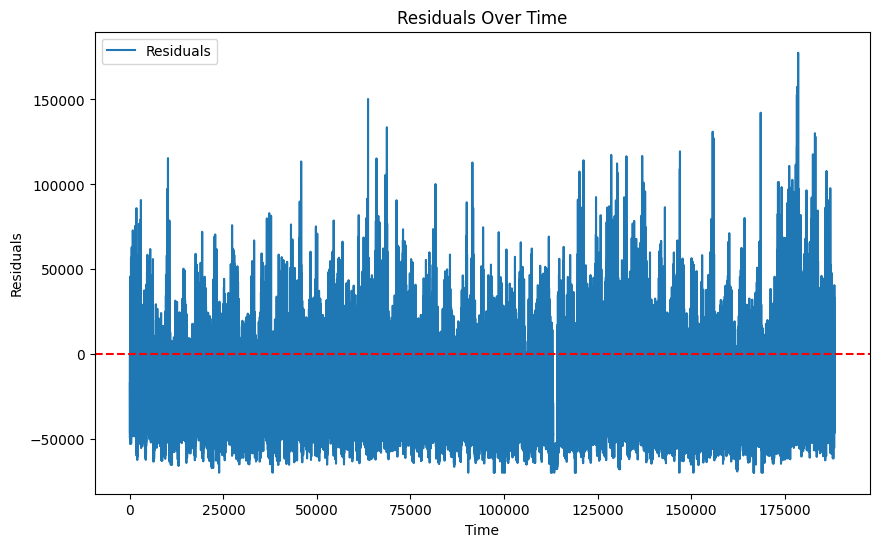

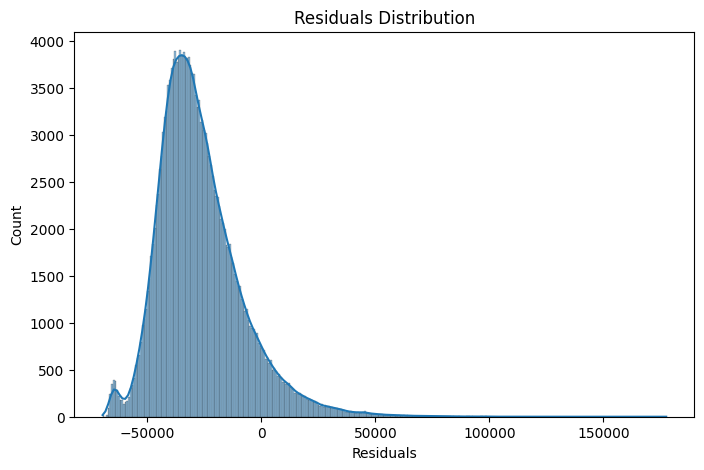

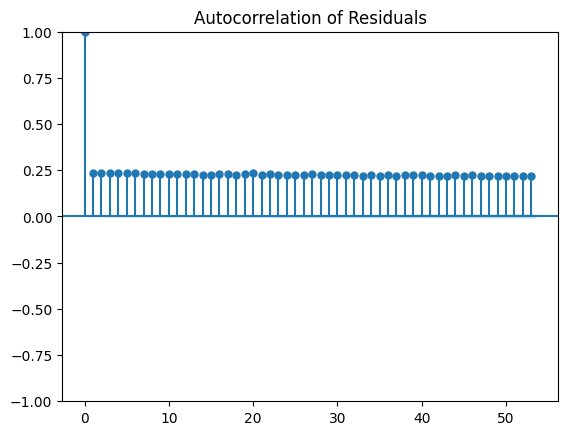

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals = y_train - y_test_pred

# Plot residuals over time
plt.figure(figsize=(10, 6))
plt.plot(residuals, label="Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.legend()
plt.title("Residuals Over Time")
plt.show()

# Distribution of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.show()

# Residuals Autocorrelation Plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals)
plt.title("Autocorrelation of Residuals")
plt.show()


**Deployment**

In [ ]:
import pandas as pd
train_df=pd.read_csv("/content/TRAIN.csv")

Steps for Deploying a Machine Learning Model via Flask API

1.Preparation and Setup

●	Environment Setup: Create a Python virtual environment and install Flask along with necessary libraries such as numpy, pandas, scikit-learn, and any other libraries used in the model.

●	Directory Structure: Organize your Flask application with proper directories for templates, static files, and the main application script.


In [ ]:
!pip install Flask numpy pandas scikit-learn joblib


In [ ]:
!pip install prophet xgboost


In [ ]:
# Set up project directory structure
!mkdir -p app/static app/templates app/models


In [ ]:
%%writefile main.py
from flask import Flask, request, jsonify, render_template
import joblib
import pandas as pd

app = Flask(__name__)

# Load pre-trained model
model = joblib.load("app/models/model.pkl")

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json if request.is_json else request.form.to_dict()
    df = pd.DataFrame([data])
    prediction = model.predict(df)
    return jsonify({'prediction': prediction.tolist()})

if __name__ == "__main__":
    app.run(debug=True)


Overwriting main.py


In [ ]:
if 'Date' in train_df.columns:
    # Ensure 'Date' is in datetime format
    train_df['Date'] = pd.to_datetime(train_df['Date'])

    # Extract useful components from the Date (optional: modify based on your data)
    train_df['Year'] = train_df['Date'].dt.year
    train_df['Month'] = train_df['Date'].dt.month
    train_df['Day'] = train_df['Date'].dt.day

    # Drop the original 'Date' column as it can't be used directly
    train_df = train_df.drop(columns=['Date'])

In [ ]:
store_type_dummies = pd.get_dummies(train_df['Store_Type'], prefix='Store_Type')

# Now concatenate the one-hot encoded columns with the original DataFrame
train_df = pd.concat([train_df, store_type_dummies], axis=1)

# If needed, you can drop the original 'Store_Type' column
train_df = train_df.drop('Store_Type', axis=1)

In [ ]:
region_code_dummies = pd.get_dummies(train_df['Region_Code'], prefix='Region_Code')

# Now concatenate the one-hot encoded columns with the original DataFrame
train_df = pd.concat([train_df, region_code_dummies], axis=1)

# If needed, you can drop the original 'Store_Type' column
train_df = train_df.drop('Region_Code', axis=1)

In [ ]:
location_type_dummies = pd.get_dummies(train_df['Location_Type'], prefix='Location_Type')

# Now concatenate the one-hot encoded columns with the original DataFrame
train_df = pd.concat([train_df, location_type_dummies], axis=1)

# If needed, you can drop the original 'Store_Type' column
train_df = train_df.drop('Location_Type', axis=1)

In [ ]:
train_df.columns

Index(['ID', 'Store_id', 'Holiday', 'Discount', '#Order', 'Sales', 'Year',
       'Month', 'Day', 'Store_Type_S1', 'Store_Type_S2', 'Store_Type_S3',
       'Store_Type_S4', 'Location_Type_L1', 'Location_Type_L2',
       'Location_Type_L3', 'Location_Type_L4', 'Location_Type_L5',
       'Region_Code_R1', 'Region_Code_R2', 'Region_Code_R3', 'Region_Code_R4'],
      dtype='object')

In [ ]:
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import pandas as pd

if 'Date' in train_df.columns:
    # Ensure 'Date' is in datetime format
    train_df['Date'] = pd.to_datetime(train_df['Date'])

    # Extract useful components from the Date (optional: modify based on your data)
    train_df['Year'] = train_df['Date'].dt.year
    train_df['Month'] = train_df['Date'].dt.month
    train_df['Day'] = train_df['Date'].dt.day

    # Drop the original 'Date' column as it can't be used directly
    train_df = train_df.drop(columns=['Date'])

# Check the columns in your DataFrame
print("Columns in train_df:", train_df.columns)

# Define the feature columns based on available columns
# Use one-hot encoded columns instead of 'Store_Type', 'Location_Type', 'Region_Code', and 'Date'
X = train_df[['Store_id', 'Holiday', 'Discount', '#Order',
              'Store_Type_S1', 'Store_Type_S2', 'Store_Type_S3', 'Store_Type_S4',
              'Location_Type_L1', 'Location_Type_L2', 'Location_Type_L3', 'Location_Type_L4', 'Location_Type_L5',
              'Region_Code_R1', 'Region_Code_R2', 'Region_Code_R3', 'Region_Code_R4',
              'Year', 'Month', 'Day']]  # Use Year, Month, and Day instead of Date

y = train_df['Sales']   # Use the target column name

# Check for columns with 'Yes' or 'No' and apply LabelEncoding
categorical_cols = ['Holiday', 'Discount']  # Specify any column that contains 'Yes'/'No' or other categorical values
label_encoder = LabelEncoder()

# Encode each categorical column
for col in categorical_cols:
    if X[col].dtype == 'object':  # Check if the column is of string type
        X[col] = label_encoder.fit_transform(X[col])

# Check for NaN values and drop rows with NaNs if necessary
if X.isnull().any().any() or y.isnull().any():
    print("There are missing values in the data. Dropping rows with NaN values.")
    train_df = train_df.dropna()
    X = train_df[['Store_id', 'Holiday', 'Discount', '#Order',
                  'Store_Type_S1', 'Store_Type_S2', 'Store_Type_S3', 'Store_Type_S4',
                  'Location_Type_L1', 'Location_Type_L2', 'Location_Type_L3', 'Location_Type_L4', 'Location_Type_L5',
                  'Region_Code_R1', 'Region_Code_R2', 'Region_Code_R3', 'Region_Code_R4',
                  'Year', 'Month', 'Day']]  # Update X after dropping NaN rows
    y = train_df['Sales']   # Update y

# Verify X and y shapes are compatible
print("X shape:", X.shape)
print("y shape:", y.shape)

# Train the model
model = RandomForestRegressor()
model.fit(X, y)

# Save the model
joblib.dump(model, 'app/models/model.pkl')


Columns in train_df: Index(['ID', 'Store_id', 'Holiday', 'Discount', '#Order', 'Sales', 'Year',
       'Month', 'Day', 'Store_Type_S1', 'Store_Type_S2', 'Store_Type_S3',
       'Store_Type_S4', 'Location_Type_L1', 'Location_Type_L2',
       'Location_Type_L3', 'Location_Type_L4', 'Location_Type_L5',
       'Region_Code_R1', 'Region_Code_R2', 'Region_Code_R3', 'Region_Code_R4'],
      dtype='object')
X shape: (188340, 20)
y shape: (188340,)


<ipython-input-15-fca43503fc0a>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoder.fit_transform(X[col])


['app/models/model.pkl']

In [ ]:
!pip install flask-ngrok

In [ ]:
from flask import Flask, request, jsonify
import joblib
import numpy as np

app = Flask(__name__)

# Load the model when the server starts
def load_model():
    global model
    model = joblib.load('app/models/model.pkl')  # Path to the saved model

# Initialize the model
load_model()

@app.route('/')
def home():
    return "Welcome to the Prediction API!"

@app.route('/predict', methods=['POST'])
def predict():
    # Get input data from the request
    data = request.get_json()  # Assuming the input data is sent as JSON
    features = np.array(data[['Store_id', 'Holiday', 'Discount', '#Order',
                  'Store_Type_S1', 'Store_Type_S2', 'Store_Type_S3', 'Store_Type_S4',
                  'Location_Type_L1', 'Location_Type_L2', 'Location_Type_L3', 'Location_Type_L4', 'Location_Type_L5',
                  'Region_Code_R1', 'Region_Code_R2', 'Region_Code_R3', 'Region_Code_R4',
                  'Year', 'Month', 'Day']]).reshape(1, -1)  # Reshaping the data into the required shape

    # Make the prediction using the loaded model
    prediction = model.predict(features)

    # Return the prediction result as JSON
    return jsonify({'prediction': prediction[0]})

if __name__ == "__main__":
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


In [ ]:
pip install Flask joblib pandas scikit-learn

In [ ]:
from flask import Flask, request, jsonify
import joblib
import pandas as pd

# Load the trained model (make sure the path matches where you saved the model)
model = joblib.load('app/models/model.pkl')

# Initialize the Flask application
app = Flask(__name__)

# Define a route for predicting sales
@app.route('/predict', methods=['POST'])
def predict_sales():
    try:
        # Get the input JSON data from the request
        data = request.get_json()

        # Check if required features are present in the request
        required_features = ['Store_id', 'Holiday', 'Discount', '#Order', 'Location_Type', 'Region_Code']
        if not all(feature in data for feature in required_features):
            return jsonify({"error": "Missing one or more required features"}), 400

        # Prepare the input data as a DataFrame
        input_data = pd.DataFrame([data])

        # Process 'Holiday' column to 1/0 if necessary (similar to the training data)
        input_data['Holiday'] = input_data['Holiday'].apply(lambda x: 1 if x == 'Yes' else (0 if x == 'No' else 0))

        # One-hot encode 'Store_id', 'Location_Type', 'Region_Code' columns
        input_data = pd.get_dummies(input_data, columns=['Store_id', 'Location_Type', 'Region_Code'], drop_first=True)

        # Ensure all columns needed by the model are present
        model_features = model.feature_names_in_
        missing_columns = set(model_features) - set(input_data.columns)
        if missing_columns:
            return jsonify({"error": f"Missing columns: {', '.join(missing_columns)}"}), 400

        # Ensure the input data is aligned with the model's expected features
        input_data = input_data[model_features]

        # Make predictions using the trained model
        predictions = model.predict(input_data)

        # Return the prediction as JSON
        return jsonify({"predicted_sales": predictions[0]}), 200

    except Exception as e:
        # Handle any errors that occur
        return jsonify({"error": str(e)}), 500

# Define a health check route
@app.route('/health', methods=['GET'])
def health_check():
    return jsonify({"status": "Model API is running"}), 200

if __name__ == '__main__':
    app.run(debug=True)


In [ ]:
import requests

# Define the input data (make sure this matches the features used by your model)
data = {
    "Store_id": 1,  # Store_id should match the encoding in the model
    "Holiday": "Yes",  # 'Yes' or 'No' for the Holiday column
    "Discount": 10,
    "#Order": 150,
    "Location_Type": "L1",  # Example value for Location_Type
    "Region_Code": "R1"  # Example value for Region_Code
}

# Send POST request to the API
response = requests.post('http://127.0.0.1:5000/predict', json=data)

# Print the response from the API
print(response.json())
